# **Capstone Project: [Deteksi Penyakit pada Tanaman Kelapa Sawit]**
**ID Group:** LAI25-RM112

**Anggota Kelompok:**
- A200YBF418_Refanda Surya Saputra - A200YBF418@devacademy.id
- A270YAF435_Risky Fahriza - A270YAF435@devacademy.id
- A528YBF449_Sebastian Luth Hasibuan - A528YBF449@devacademy.id
- A184YBF450_Sefza Auma Alam - A184YBF450@devacademy.id

## **Import Libraries/Packages**

In [1]:
import os
import random
import shutil
import warnings
import zipfile

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
from keras import Model, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import TFSMLayer, Input, Flatten
from tensorflow.keras.callbacks import Callback
from tensorflow.saved_model import save

from PIL import Image
from skimage import io
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.transform import rotate, AffineTransform, warp
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm as tq

import gdown
from google.colab import drive

warnings.simplefilter(action='ignore', category=FutureWarning)

print(tf.__version__)

2.18.0


## **Loading Data**

### **Preparation Data**

Menggunakan dataset dari google drive pada google colab

In [2]:
# Mounting dari google drive
drive.mount('/content/drive')

# Mengakses dataset di google drive
dataset_path = '/content/drive/My Drive/Capstone LAI25-RM112/Dataset/palm-disease-dataset.zip'

# Ekstrak dataset
with zipfile.ZipFile(dataset_path, 'r') as zip_file:
    zip_file.extractall('/content/dataset')

Mounted at /content/drive


Mengunduh dataset ke penyimpanan lokal

In [ ]:
# Ketika menggunakan IDE lokal
file_id = "1c9iWUpGHYl-eq057RheOT6q2-hcpj9F4"
url = f"https://drive.google.com/uc?id={file_id}"

gdown.download(url, 'palm-disease-dataset.zip', quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1c9iWUpGHYl-eq057RheOT6q2-hcpj9F4
From (redirected): https://drive.google.com/uc?id=1c9iWUpGHYl-eq057RheOT6q2-hcpj9F4&confirm=t&uuid=4c716aa7-8a38-4c83-9b1a-f0007b46edad
To: /home/refanzzzz/PycharmProjects/CP-Laskar-AI-LAI25-RM112/palm-disease-dataset.zip
100%|██████████| 779M/779M [02:49<00:00, 4.59MB/s] 


'palm-disease-dataset.zip'

In [ ]:
# Unzip berkas yang telah diuduh dari google drive
with zipfile.ZipFile('palm-disease-dataset.zip', 'r') as zip_file:
    zip_file.extractall()

### **Checking Dataset**

In [3]:
# Mengecek label pada dataset
palm_disease_path  = "dataset/palm-disease-dataset"

# Menyimpan label
list_label = os.listdir(palm_disease_path)

# Menampilkan list label
list_label

['Magnesium Deficiency', 'Healthy', 'Fungal Disease', 'Scale Insect']

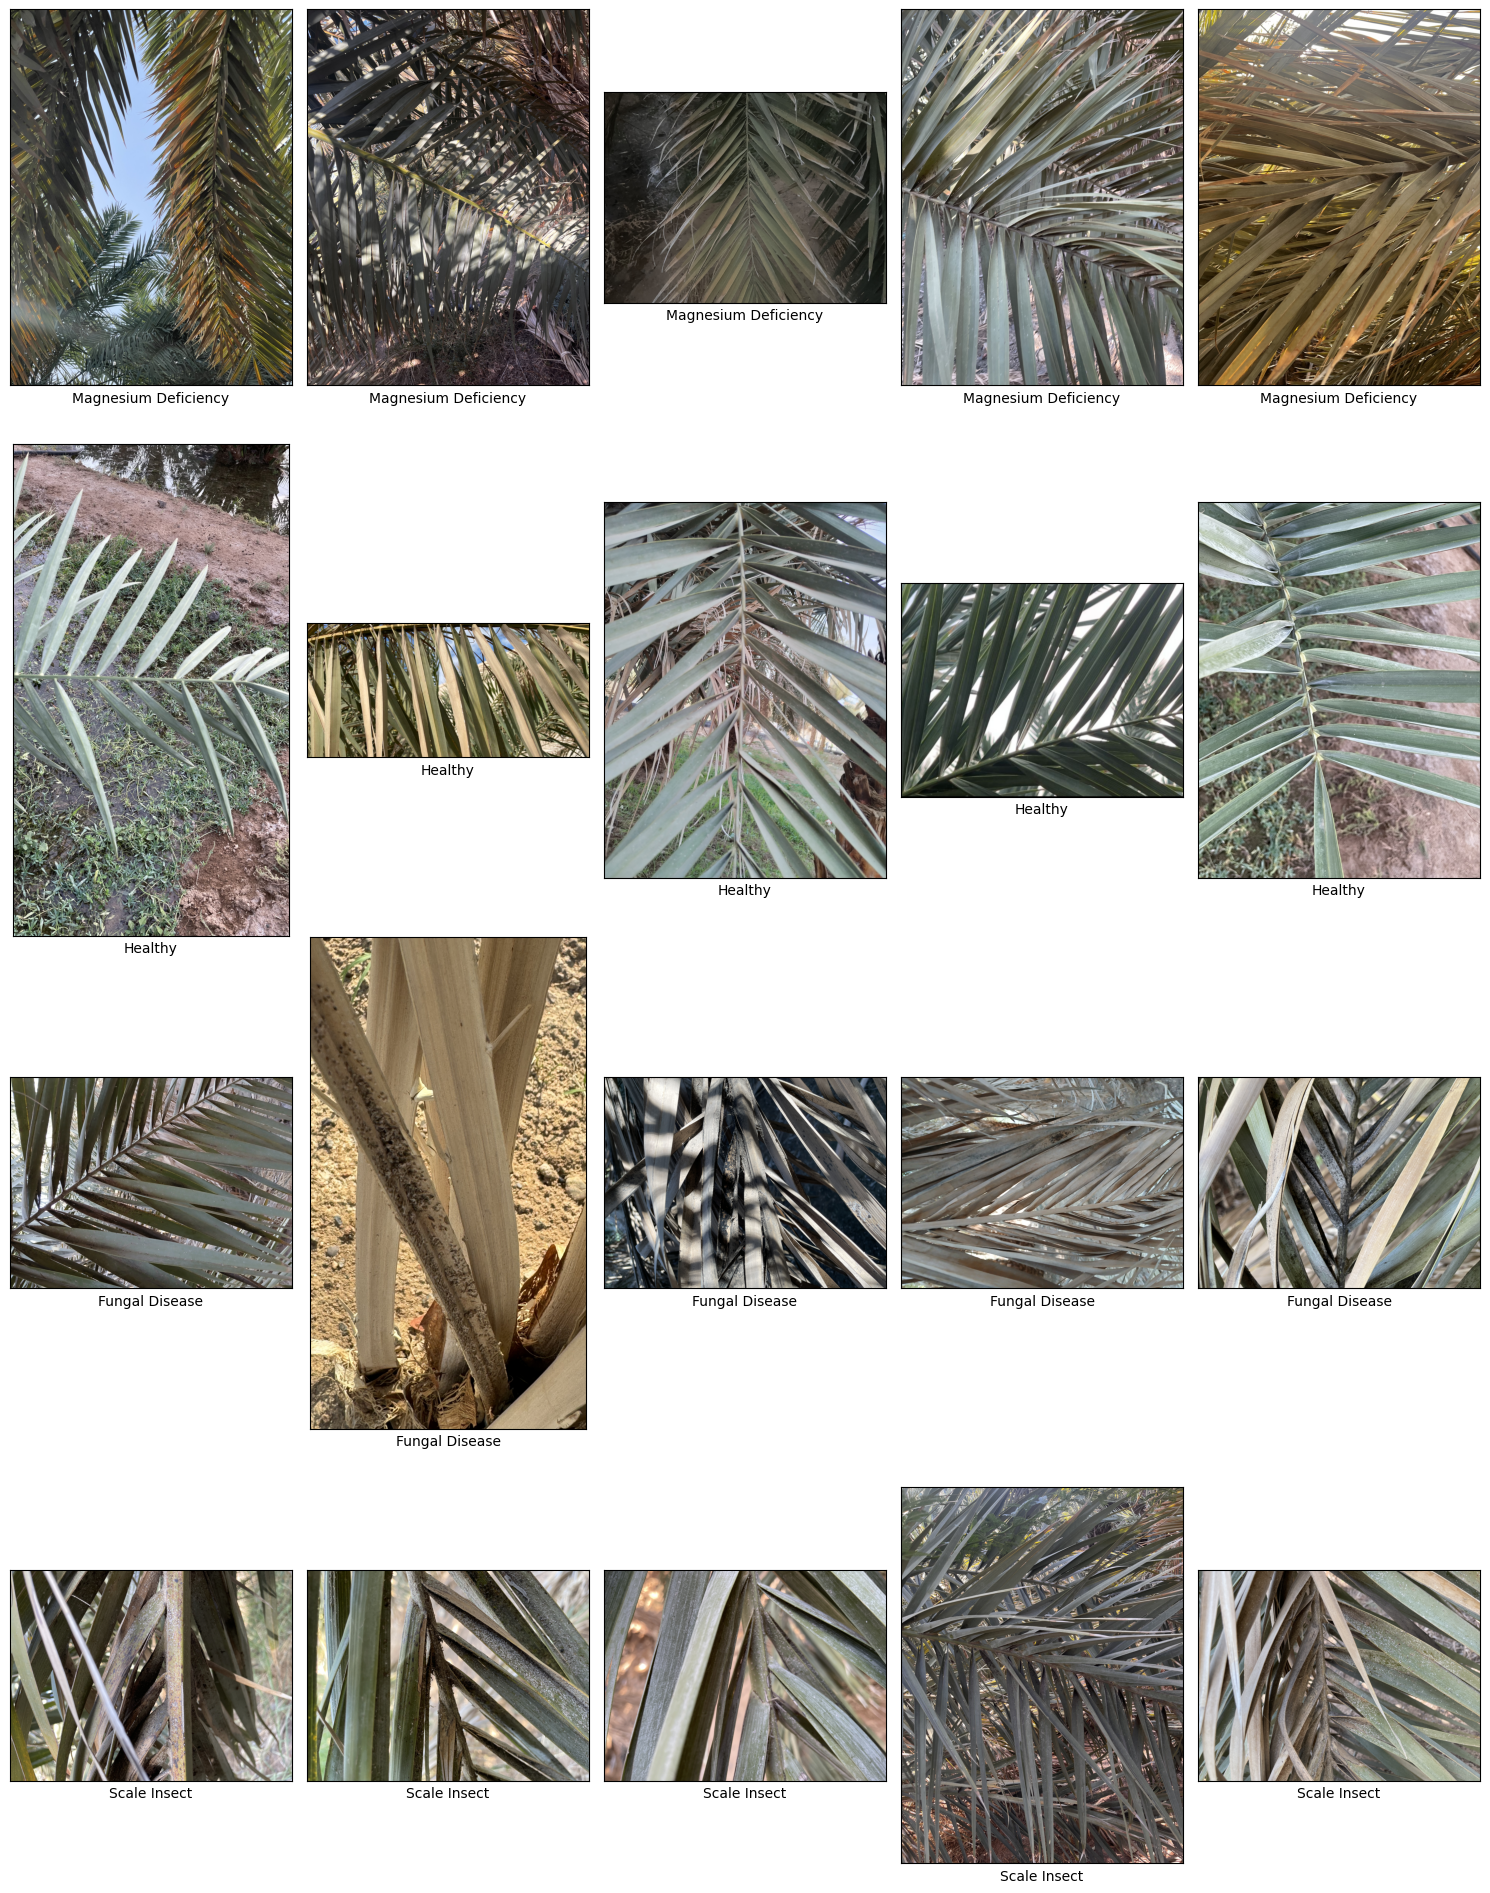

In [4]:
# Membuat dictionary untuk menyimpan gambar untuk setiap kelas dalam data
palm_disease_image = {}

# Menentukan path sumber dataset
source_path = "dataset/palm-disease-dataset/"

for i in os.listdir(source_path):
  palm_disease_image[i]  = os.listdir(source_path + i)

# menampilkan secara acak 5 gambar untuk masing-masing kelas
fig, ax = plt.subplots(4, 5, figsize=(15, 20))

for i, label in enumerate(os.listdir(source_path)):
  images = np.random.choice(palm_disease_image[label], 5, replace=False)
  for j, image in enumerate(images):
    img_path = os.path.join(source_path, label, image)
    img = Image.open(img_path)
    ax[i, j].imshow(img)
    ax[i, j].set(xlabel=label, xticks=[], yticks=[])

fig.tight_layout()

In [5]:
# Membuat fungsi untuk melihat jumlah image tiap-tiap kelas
def get_image_count(path):
  image_count = {}
  for label in os.listdir(path):
    image_count[label] = len(os.listdir(os.path.join(path, label)))
  return image_count

print(get_image_count(source_path))

{'Magnesium Deficiency': 69, 'Healthy': 37, 'Fungal Disease': 53, 'Scale Insect': 80}


### **Distribution Plot of Class Dataset**

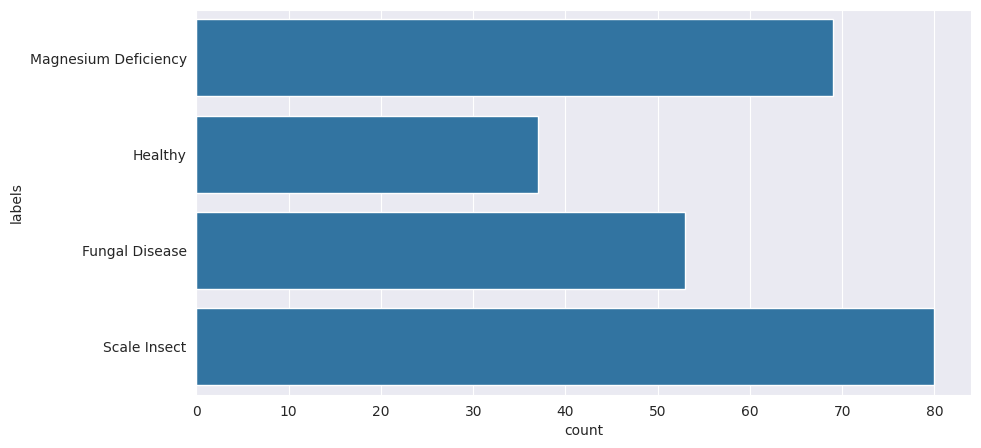

In [6]:
def plot_distribution(path):
  # Membuat daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
  file_name = []
  labels = []
  full_path = []

  # Mendapatkan nama file gambar, path file, dan label satu per satu dengan looping, dan simpan sebagai DataFrame
  for path, subdirs, files in os.walk(path):
    for name in files:
      file_name.append(name)
      labels.append(path.split('/')[-1])
      full_path.append(os.path.join(path, name))

  distribution_train = pd.DataFrame({
      'path': full_path,
      'file_name': file_name,
      'labels': labels
  })

  # Plot distribusi gambar setiap kelas
  label = distribution_train['labels']
  plt.figure(figsize=(10, 5))
  sns.set_style('darkgrid')
  sns.countplot(label)

plot_distribution(source_path)

## **Preprocessing Data**


### **Augmentation Data**

In [7]:
# Membuat fungsi untuk melakukan rotasi berlawanan arah jarum jam
def anticlockwise_rotation(img):
  img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
  img = cv2.resize(img, (224, 224))
  angle = random.randint(0, 180)
  return rotate(img, angle)

# Membuat fungsi untuk melakukan rotasi searah jarum ram
def clockwise_rotation(img):
  img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
  img = cv2.resize(img, (224, 224))
  angle = random.randint(0, 180)
  return rotate(img, -angle)

# Membuat fungsi untuk memberikan efek peningkatan kecerahan pada gambar
def add_brightness(img):
  img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
  img = cv2.resize(img, (224, 224))
  img = adjust_gamma(img, gamma=0.5)
  return img

# Membuat fungsi untuk memberikan efek pergeseran acak pada gambar
def sheared(img):
  img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
  img = cv2.resize(img, (224, 224))
  transform = AffineTransform(shear=0.2)
  shear_img = warp(img, transform, mode='wrap')
  return shear_img

# Membuat fungsi untuk melakukan pergeseran melengkung pada gambar
def warp_shift(img):
  img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
  img = cv2.resize(img, (224, 224))
  transform = AffineTransform(translation=(0, 40))
  warp_img = warp(img, transform, mode='wrap')
  return warp_img

# Membuat fungsi untuk memberikan efek blur pada gambar
def blur_image(img):
  img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
  img = cv2.resize(img, (224, 224))
  return cv2.GaussianBlur(img, (9, 9), 0)

# Membuat fungsi untuk membalik gambar secara vertikal dari atas ke bawah
def flip_up_down(img):
  img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
  img = cv2.resize(img, (224, 224))
  return np.flipud(img)

# Membuat fungsi untuk membalik gambar secara horizontal dari kiri ke kanan
def flip_left_right(img):
  img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
  img = cv2.resize(img, (224, 224))
  return np.fliplr(img)

In [8]:
# Membuat varabel transofrmasi yang akan menyimpan semua proses pra-pemrosesan yang telah dilakukan sebelumnya
transformations = {
    'anticlockwise_rotation': anticlockwise_rotation,
    'clockwise_rotation': clockwise_rotation,
    'add_brightness': add_brightness,
    'sheared': sheared,
    'warp_shift': warp_shift,
    'blur_image': blur_image,
    'flip_up_down': flip_up_down,
    'flip_left_right': flip_left_right
}

def generate_augmented_image(image_class_name, source_image_path, num_augmented_images):
  img_processed_path = os.path.join(source_image_path, image_class_name)

  processed_images = []

  for img in os.listdir(img_processed_path):
    processed_images.append(os.path.join(img_processed_path, img))

  images_to_generate = num_augmented_images - len(os.listdir(img_processed_path))

  i = 1

  while i <= images_to_generate:
    random_image = random.choice(processed_images)

    try:
      original_image = io.imread(random_image)
      transformed_image = None

      num_transformations_to_apply = random.randint(1, len(transformations))

      num_transformations = 0

      while num_transformations <= num_transformations_to_apply:
        key = random.choice(list(transformations))
        transformed_image = transformations[key](original_image)
        num_transformations += 1

      new_image_path = "%s/augmented_image_%s.jpg" % (img_processed_path, i)
      transformed_image = img_as_ubyte(transformed_image)
      cv2.imwrite(new_image_path, transformed_image)
      i += 1
    except Exception as e:
      print('Could not read the', image, ':', e, 'hence skipping it.')

In [9]:
for label in list_label:
  generate_augmented_image(label, source_path, 300)

Could not read the IMG_1138.JPG : Could not find a backend to open `dataset/palm-disease-dataset/Magnesium Deficiency/M6_63`` with iomode `r`. hence skipping it.
Could not read the IMG_1138.JPG : Could not find a backend to open `dataset/palm-disease-dataset/Magnesium Deficiency/M6_50`` with iomode `r`. hence skipping it.
Could not read the IMG_1138.JPG : Could not find a backend to open `dataset/palm-disease-dataset/Magnesium Deficiency/M6_50`` with iomode `r`. hence skipping it.
Could not read the IMG_1138.JPG : Could not find a backend to open `dataset/palm-disease-dataset/Magnesium Deficiency/M6_64`` with iomode `r`. hence skipping it.
Could not read the IMG_1138.JPG : Could not find a backend to open `dataset/palm-disease-dataset/Magnesium Deficiency/M6_43`` with iomode `r`. hence skipping it.
Could not read the IMG_1138.JPG : Could not find a backend to open `dataset/palm-disease-dataset/Magnesium Deficiency/M6_64`` with iomode `r`. hence skipping it.
Could not read the IMG_1138.

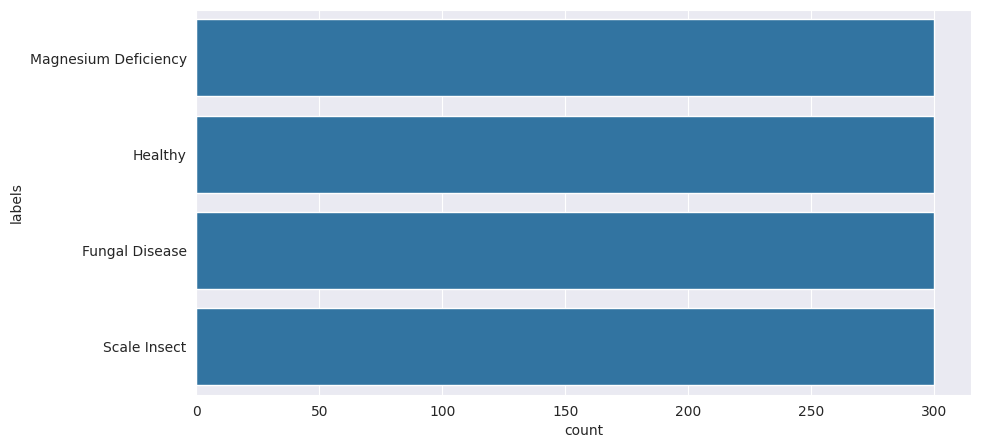

In [10]:
# Melihat plot distribusi kelas setelah dilakukan augmentasi
plot_distribution(source_path)

### **Spliting Data**

In [11]:
# Membuat variabel untuk menampung lokasi folder dari dataset gambar
source_path = 'dataset/palm-disease-dataset/'

file_name = []
labels = []
full_path = []

for path, subdirs, files in os.walk(source_path):
  for name in files:
    file_name.append(name)
    labels.append(path.split('/')[-1])
    full_path.append(os.path.join(path, name))

# Memasukkan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah DataFrame
image_df = pd.DataFrame({
    'file_name': file_name,
    'labels': labels,
    'full_path': full_path
})

# Melihat jumlah data gambar pada masing-masing label
image_df['labels'].value_counts()

labels
Magnesium Deficiency    300
Healthy                 300
Fungal Disease          300
Scale Insect            300
Name: count, dtype: int64

In [12]:
# variabel yang digunaka pada pemisahan data ini, di mana variabel x = data path dan y = data labels
X = image_df['full_path']
y = image_df['labels']

# Split dataset awal menjadi data train dan temp (test dan validasi)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Menyatukan ke dalam maisng-masing DataFrame
df_train = pd.DataFrame({
    'path': X_train,
    'labels': y_train,
    'set': 'train'
})

df_validation = pd.DataFrame({
    'path': X_val,
    'labels': y_val,
    'set': 'validation'
})

df_test = pd.DataFrame({
    'path': X_test,
    'labels': y_test,
    'set': 'test'
})

# Menggabungkan DataFrame df_train, df_test, dan df_validation
df_all = pd.concat([df_train, df_validation, df_test], ignore_index=True)
print(df_all.groupby(['set', 'labels']).size())

set         labels              
test        Fungal Disease           45
            Healthy                  45
            Magnesium Deficiency     45
            Scale Insect             45
train       Fungal Disease          210
            Healthy                 210
            Magnesium Deficiency    210
            Scale Insect            210
validation  Fungal Disease           45
            Healthy                  45
            Magnesium Deficiency     45
            Scale Insect             45
dtype: int64


In [13]:
# Mengecek sampel data
print(df_all.sample(5))

                                                   path                labels  \
266   dataset/palm-disease-dataset/Magnesium Deficie...  Magnesium Deficiency   
610   dataset/palm-disease-dataset/Scale Insect/augm...          Scale Insect   
524   dataset/palm-disease-dataset/Healthy/augmented...               Healthy   
1071  dataset/palm-disease-dataset/Magnesium Deficie...  Magnesium Deficiency   
439   dataset/palm-disease-dataset/Healthy/augmented...               Healthy   

        set  
266   train  
610   train  
524   train  
1071   test  
439   train  


In [14]:
# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = 'dataset/palm-disease-dataset/'

# Membuat variabel dataset, tempat menampung data yang telah dilakukan splitting
dataset_path = 'dataset/final-dataset/'

for index, row in tq(df_all.iterrows()):
  file_path = row['path']

  if os.path.exists(file_path) == False:
    file_path = os.path.join(datasource_path, row['labels'], row['image'].split('.')[0])

  # Membuat direktori tujuan folder
  if os.path.exists(os.path.join(dataset_path, row['set'], row['labels'])) == False:
    os.makedirs(os.path.join(dataset_path, row['set'], row['labels']))

  # Menentukan tujuan file
  destination_file_name = file_path.split('/')[-1]
  destination_path = os.path.join(dataset_path, row['set'], row['labels'], destination_file_name)

  # Memindahkan file ke direktori tujuan
  if os.path.exists(destination_path) == False:
    shutil.copy2(file_path, destination_path)

0it [00:00, ?it/s]

### **Image Data Generator**

In [15]:
# Mendefinisikan direktori daset training, test, dan validation
TRAIN_DIR = "dataset/final-dataset/train"
TEST_DIR = "dataset/final-dataset/test"
VAL_DIR = "dataset/final-dataset/validation"

# Membuat fungsi untuk menampilkan jumlah data train berdasarkan label
def print_total_train_data(label):
  train_temp = os.path.join(TRAIN_DIR, label)
  train_count = len(os.listdir(train_temp))
  print("Total train data for {} is {}".format(label, train_count))

# Membuat fungsi untuk menampilkan jumlah data test berdasarkan label
def print_total_test_data(label):
  test_temp = os.path.join(TEST_DIR, label)
  test_count = len(os.listdir(test_temp))
  print("Total test data for {} is {}".format(label, test_count))

# Membuat fungsi untuk menampilkan jumlah data validation berdasarkan label
def print_total_validation_data(label):
  val_temp = os.path.join(VAL_DIR, label)
  val_count = len(os.listdir(val_temp))
  print("Total validation data for {} is {}".format(label, val_count))

for label in list_label:
  print_total_train_data(label)
  print_total_test_data(label)
  print_total_validation_data(label)
  print("\n")

Total train data for Magnesium Deficiency is 210
Total test data for Magnesium Deficiency is 45
Total validation data for Magnesium Deficiency is 45


Total train data for Healthy is 210
Total test data for Healthy is 45
Total validation data for Healthy is 45


Total train data for Fungal Disease is 210
Total test data for Fungal Disease is 45
Total validation data for Fungal Disease is 45


Total train data for Scale Insect is 210
Total test data for Scale Insect is 45
Total validation data for Scale Insect is 45




In [16]:
# Membuat objek ImageDataGeneratir untuk menormalisasikan gambar
train_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = ImageDataGenerator(rescale=1. / 255)
val_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    seed=42,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

validation_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    seed=42,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    seed=42,
    target_size=(150, 150),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

Found 837 images belonging to 4 classes.
Found 180 images belonging to 4 classes.
Found 179 images belonging to 4 classes.


## **Building Model**

### **Model Experiment 1**

In [17]:
# Inisialisasi model sekuensial
model_1 = Sequential()

model_1.add(Input(shape=(150, 150, 3)))

model_1.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model_1.add(BatchNormalization())
model_1.add(MaxPooling2D(pool_size=(2, 2)))

model_1.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model_1.add(BatchNormalization())
model_1.add(MaxPooling2D(pool_size=(2, 2)))

model_1.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model_1.add(BatchNormalization())
model_1.add(MaxPooling2D(pool_size=(2, 2)))

model_1.add(Flatten())

model_1.add(Dense(256, activation='relu'))
model_1.add(Dropout(0.5))

model_1.add(Dense(64, activation='relu'))
model_1.add(Dropout(0.3))

model_1.add(Dense(len(list_label), activation='softmax'))

model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# rangkuman arsitektur model
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    10,617,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,727,940 (40.92 MB)

 Trainable params: 10,727,492 (40.92 MB)

 Non-trainable params: 448 (1.75 KB)

In [18]:
# Membuat callback
checkpoint = ModelCheckpoint('model_1.h5', monitor='val_loss', save_best_only=True, mode='min')

# Membuat custom callback
class EpochCheckpoint(Callback):
  def on_epoch_end(self, epoch, logs={}):
    if (logs.get('accuracy') > 0.95):
      print("[INFO] Reached 95% accuracy, stopping training")
      self.model.stop_training = True

epoch_checkpoint = EpochCheckpoint()

In [19]:
# Fitting / training model
history_model_1 = model_1.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[checkpoint, epoch_checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3204 - loss: 10.1362

27/27 ━━━━━━━━━━━━━━━━━━━━ 99s 3s/step - accuracy: 0.3206 - loss: 10.1123 - val_accuracy: 0.2500 - val_loss: 3.9539
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - accuracy: 0.4183 - loss: 6.7996 - val_accuracy: 0.2500 - val_loss: 14.3660
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 93s 4s/step - accuracy: 0.3890 - loss: 5.3421 - val_accuracy: 0.2556 - val_loss: 12.9162
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 99s 4s/step - accuracy: 0.4310 - loss: 3.3535 - val_accuracy: 0.2500 - val_loss: 13.5203
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 96s 4s/step - accuracy: 0.4208 - loss: 2.5686 - val_accuracy: 0.2444 - val_loss: 6.4827
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4685 - loss: 2.1250

27/27 ━━━━━━━━━━━━━━━━━━━━ 94s 4s/step - accuracy: 0.4678 - loss: 2.1292 - val_accuracy: 0.3667 - val_loss: 2.5209
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4282 - loss: 2.0775

27/27 ━━━━━━━━━━━━━━━━━━━━ 100s 4s/step - accuracy: 0.4280 - loss: 2.0785 - val_accuracy: 0.3389 - val_loss: 1.9678
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4704 - loss: 1.7153

27/27 ━━━━━━━━━━━━━━━━━━━━ 97s 4s/step - accuracy: 0.4707 - loss: 1.7127 - val_accuracy: 0.3889 - val_loss: 1.7949
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 100s 4s/step - accuracy: 0.4896 - loss: 1.5140 - val_accuracy: 0.3389 - val_loss: 2.3440
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 94s 3s/step - accuracy: 0.5251 - loss: 1.4179 - val_accuracy: 0.3667 - val_loss: 1.8664
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5824 - loss: 1.4560

27/27 ━━━━━━━━━━━━━━━━━━━━ 98s 4s/step - accuracy: 0.5808 - loss: 1.4562 - val_accuracy: 0.3389 - val_loss: 1.4521
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 138s 3s/step - accuracy: 0.5403 - loss: 1.1802 - val_accuracy: 0.3444 - val_loss: 1.8205
Epoch 13/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5784 - loss: 1.1191

27/27 ━━━━━━━━━━━━━━━━━━━━ 144s 4s/step - accuracy: 0.5780 - loss: 1.1211 - val_accuracy: 0.4556 - val_loss: 1.2472
Epoch 14/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 99s 4s/step - accuracy: 0.6125 - loss: 1.0791 - val_accuracy: 0.4333 - val_loss: 1.2641
Epoch 15/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 100s 4s/step - accuracy: 0.6165 - loss: 1.0619 - val_accuracy: 0.4500 - val_loss: 1.3860
Epoch 16/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 91s 3s/step - accuracy: 0.6320 - loss: 1.0061 - val_accuracy: 0.4778 - val_loss: 1.3237
Epoch 17/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step - accuracy: 0.6966 - loss: 0.7973 - val_accuracy: 0.4944 - val_loss: 1.6392
Epoch 18/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 90s 3s/step - accuracy: 0.6842 - loss: 0.8635 - val_accuracy: 0.5333 - val_loss: 1.2818
Epoch 19/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6753 - loss: 0.9386

27/27 ━━━━━━━━━━━━━━━━━━━━ 90s 3s/step - accuracy: 0.6754 - loss: 0.9386 - val_accuracy: 0.5667 - val_loss: 1.0703
Epoch 20/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6854 - loss: 0.8684

27/27 ━━━━━━━━━━━━━━━━━━━━ 90s 3s/step - accuracy: 0.6859 - loss: 0.8665 - val_accuracy: 0.6222 - val_loss: 0.9844
Epoch 21/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7105 - loss: 0.7462

27/27 ━━━━━━━━━━━━━━━━━━━━ 90s 3s/step - accuracy: 0.7104 - loss: 0.7479 - val_accuracy: 0.6722 - val_loss: 0.8813
Epoch 22/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 89s 3s/step - accuracy: 0.6767 - loss: 0.8700 - val_accuracy: 0.6611 - val_loss: 0.9178
Epoch 23/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 89s 3s/step - accuracy: 0.7425 - loss: 0.8157 - val_accuracy: 0.4778 - val_loss: 2.5233
Epoch 24/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 89s 3s/step - accuracy: 0.7395 - loss: 0.7535 - val_accuracy: 0.4056 - val_loss: 1.9272
Epoch 25/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 90s 3s/step - accuracy: 0.7429 - loss: 0.7301 - val_accuracy: 0.4444 - val_loss: 2.4611
Epoch 26/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - accuracy: 0.7600 - loss: 0.6959 - val_accuracy: 0.5056 - val_loss: 2.6276
Epoch 27/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 89s 3s/step - accuracy: 0.7965 - loss: 0.5769 - val_accuracy: 0.6556 - val_loss: 1.0809
Epoch 28/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 88s 3s/step - accuracy: 0.8050 - loss: 0.5394 - val_accuracy: 0.6389 - val_loss: 1.

27/27 ━━━━━━━━━━━━━━━━━━━━ 90s 3s/step - accuracy: 0.7987 - loss: 0.5763 - val_accuracy: 0.7111 - val_loss: 0.8020
Epoch 30/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - accuracy: 0.8236 - loss: 0.5012 - val_accuracy: 0.6500 - val_loss: 0.9352
Epoch 31/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 88s 3s/step - accuracy: 0.8607 - loss: 0.4416 - val_accuracy: 0.5833 - val_loss: 1.2995
Epoch 32/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 89s 3s/step - accuracy: 0.8612 - loss: 0.3783 - val_accuracy: 0.6722 - val_loss: 0.8161
Epoch 33/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8655 - loss: 0.3697

27/27 ━━━━━━━━━━━━━━━━━━━━ 91s 3s/step - accuracy: 0.8650 - loss: 0.3714 - val_accuracy: 0.7444 - val_loss: 0.7448
Epoch 34/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 96s 4s/step - accuracy: 0.8609 - loss: 0.3931 - val_accuracy: 0.6722 - val_loss: 1.0582
Epoch 35/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 92s 3s/step - accuracy: 0.8406 - loss: 0.4448 - val_accuracy: 0.7556 - val_loss: 0.7658
Epoch 36/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 96s 4s/step - accuracy: 0.8737 - loss: 0.3407 - val_accuracy: 0.7222 - val_loss: 0.9149
Epoch 37/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 92s 3s/step - accuracy: 0.8779 - loss: 0.3193 - val_accuracy: 0.7000 - val_loss: 0.9891
Epoch 38/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 92s 3s/step - accuracy: 0.8981 - loss: 0.2455 - val_accuracy: 0.6444 - val_loss: 1.0111
Epoch 39/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 93s 3s/step - accuracy: 0.8496 - loss: 0.3882 - val_accuracy: 0.7556 - val_loss: 0.8976
Epoch 40/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 91s 3s/step - accuracy: 0.8938 - loss: 0.2789 - val_accuracy: 0.6833 - val_loss: 1.2

27/27 ━━━━━━━━━━━━━━━━━━━━ 93s 3s/step - accuracy: 0.8890 - loss: 0.3274 - val_accuracy: 0.7611 - val_loss: 0.6652
Epoch 42/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - accuracy: 0.9331 - loss: 0.2089 - val_accuracy: 0.7000 - val_loss: 1.0838
Epoch 43/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 91s 3s/step - accuracy: 0.9122 - loss: 0.2078 - val_accuracy: 0.7167 - val_loss: 0.8409
Epoch 44/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 90s 3s/step - accuracy: 0.9005 - loss: 0.2691 - val_accuracy: 0.6889 - val_loss: 1.4426
Epoch 45/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 96s 4s/step - accuracy: 0.8967 - loss: 0.2982 - val_accuracy: 0.7444 - val_loss: 0.8826
Epoch 46/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 92s 3s/step - accuracy: 0.9248 - loss: 0.2106 - val_accuracy: 0.7333 - val_loss: 0.7063
Epoch 47/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 91s 3s/step - accuracy: 0.9213 - loss: 0.2255 - val_accuracy: 0.6944 - val_loss: 0.9352
Epoch 48/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 93s 3s/step - accuracy: 0.9343 - loss: 0.1696 - val_accuracy: 0.6333 - val_loss: 2.

### **Model Experiment 2**

### **Model Experiment 3**

### **Model Transfer Learning**

## **Evaluating Model**

### **Evaluating Model 1**

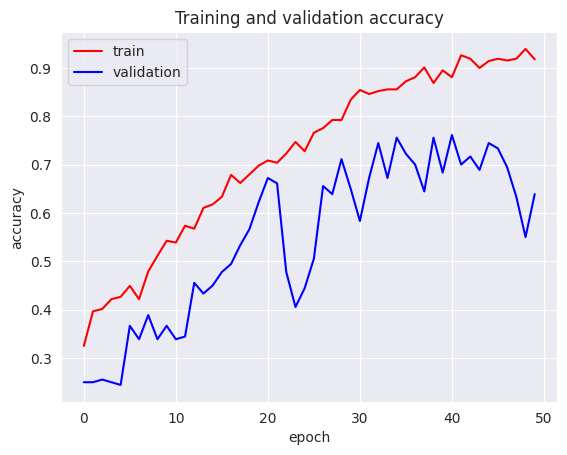

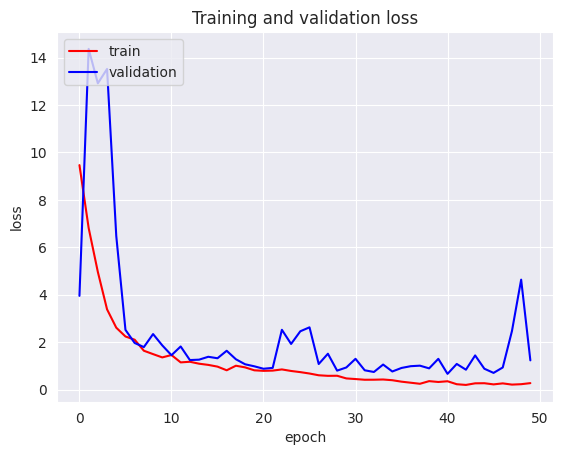

In [20]:
acc_1 = history_model_1.history['accuracy']
val_acc_1 = history_model_1.history['val_accuracy']
loss_1 = history_model_1.history['loss']
val_loss_1 = history_model_1.history['val_loss']

epochs = range(len(acc_1))

def plot_model_result(epochs, acc, val_acc, loss, val_loss):
  plt.plot(epochs, acc, 'r')
  plt.plot(epochs, val_acc, 'b')
  plt.title('Training and validation accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

  plt.plot(epochs, loss, 'r')
  plt.plot(epochs, val_loss, 'b')
  plt.title('Training and validation loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

plot_model_result(epochs, acc_1, val_acc_1, loss_1, val_loss_1)

In [22]:
# Evaluasi model menggunakan data pengujian
evaluation_model_1 = model_1.evaluate(test_generator)

# Menampilkan hasil evaluasi
print('Test Loss:', evaluation_model_1[0])
print('Test Accuracy:', evaluation_model_1[1])

179/179 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.8167 - loss: 0.6286
Test Loss: 1.2731549739837646
Test Accuracy: 0.6703910827636719


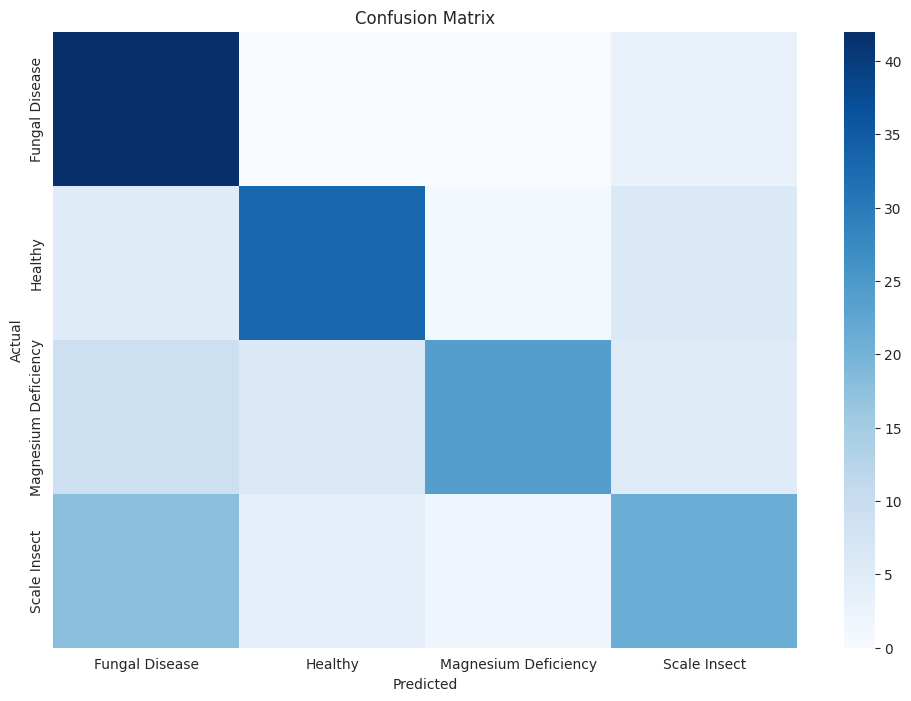

In [23]:
test_generator.reset()

preds_1 = model_1.predict(test_generator, verbose=0)
y_pred = preds_1.argmax(axis=1)
y_true = test_generator.classes

class_names = list(test_generator.class_indices.keys())

# Menampilkan confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [24]:
# Menampilkan classification report
print(classification_report(y_true, y_pred, target_names=class_names))

                      precision    recall  f1-score   support

      Fungal Disease       0.57      0.93      0.71        45
             Healthy       0.77      0.73      0.75        45
Magnesium Deficiency       0.89      0.55      0.68        44
        Scale Insect       0.60      0.47      0.53        45

            accuracy                           0.67       179
           macro avg       0.71      0.67      0.66       179
        weighted avg       0.70      0.67      0.66       179



### **Evaluating Model 2**

### **Evaluating Model 3**

### **Evaluating Model Transfer Learning**

## **Converting Model**

Melakukan konversi model ke format SavedModel untuk model dengan akurasi dataset training dan test paling optimal

In [41]:
# Konversi model ke format SavedModel
saved_path = 'model/saved_model'
save(model_1, saved_path)

## **Inferring Model**

Menggunakan model dengan nilai akurasi pada dataset test dan training paling optimal

In [39]:
# Path ke model SavedModel
model_path = 'model/saved_model'

model = load_model('model_1.h5')